In [ ]:
# Install essential libraries

!pip install yfinance
!pip install pandas
!pip install matplotlib
!pip install stockstats
!pip install gym 
!pip install stable-baselines[mpi] 
!pip install tensorflow==1.15.4 
!pip install git+https://github.com/quantopian/pyfolio 

  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-a3gexyh_
  Running command git clone -q https://github.com/quantopian/pyfolio /tmp/pip-req-build-a3gexyh_
  Created wheel for pyfolio: filename=pyfolio-0.9.2+75.g4b901f6-cp37-none-any.whl size=75764 sha256=48305f848c496c3c9c0357c435402bd5e4c82550371dd389f4647cf66f5a8d8a
  Stored in directory: /tmp/pip-ephem-wheel-cache-vsvyjery/wheels/62/7d/a7/3e462442ba7d63c35414176627c886340521dc3dbc0893ce9f
Successfully built pyfolio


In [ ]:
# Import libraries

import pandas as pd
import numpy as np


import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')


import datetime


import pathlib
import os


import warnings
warnings.filterwarnings('ignore')



from gym.utils import seeding
import gym
from gym import spaces

In [ ]:
#Configure parameters

# Directory name for Saving the models
DATA_SAVE_DIR = f"datasets"
TRAINED_MODEL_DIR = f"trained_models"
RESULTS_DIR = f"results"


START_DATE = "2009-01-01"
END_DATE = "2021-03-31"

START_TRADE_DATE = "2020-01-01"


DEFAULT_DATA_COLUMNS = ['date','tic','close']


TECHNICAL_INDICATORS_LIST = ['macd', 'rsi_30', 'cci_30', 'dx_30']


# Model Parameters

PPO_PARAMS = {'n_steps':128, 
			  'ent_coef':0.01, 
			  'learning_rate':0.00025,   
			  'nminibatches':4,
			  'verbose':0,
			  'timesteps':20000}

# Stock Name
SINGLE_TICKER =['TSLA']

In [ ]:
import yfinance as yf

class YahooDownloader:

    def __init__(self, 
        start_date:str,
        end_date:str,
        ticker_list:list):

        self.start_date = start_date
        self.end_date = end_date
        self.ticker_list = ticker_list


    def fetch_data(self) -> pd.DataFrame:

        data_df = pd.DataFrame()
        for tic in self.ticker_list:
            temp_df = yf.download(tic, start=self.start_date, end=self.end_date)
            temp_df['tic'] = tic
            data_df=data_df.append(temp_df)
        data_df=data_df.reset_index()
        try:
            data_df.columns = ['date','open','high','low','close','adjcp','volume','tic']
            
            data_df['close'] = data_df['adjcp']
            
            data_df = data_df.drop('adjcp', 1)
        except NotImplementedError:
            print("the features are not supported currently")

        data_df['date']=data_df.date.apply(lambda x: x.strftime('%Y-%m-%d'))
        data_df = data_df.dropna()
        data_df = data_df.reset_index(drop=True)
        print("Shape of DataFrame: ", data_df.shape)

        return data_df

In [ ]:
# Preprocessing

from stockstats import StockDataFrame as Sdf


class FeatureEngineer:

    def __init__(self, 
        df,
        feature_number = 5,
        use_technical_indicator=True,
        use_turbulence=False):

        self.df = df
        self.feature_number = feature_number

        
        type_list = self.__get_type_list(feature_number)
        
        self.__features = type_list

        self.__data_columns = DEFAULT_DATA_COLUMNS + self.__features
        
        self.use_technical_indicator = use_technical_indicator


        self.tech_indicator_list = TECHNICAL_INDICATORS_LIST
        self.use_turbulence=use_turbulence


    def preprocess_data(self):

        df = self.df.copy()

        if (self.use_technical_indicator==True) & (self.feature_number>=5):
            df=self.__add_technical_indicator(df)
            print("Successfully added technical indicators")

        if self.use_turbulence==True:
            df = self.__add_turbulence(df)
            print("Successfully added turbulence index")

       
        df=df.fillna(method='bfill').fillna(method="ffill")
        return df


    def __add_technical_indicator(self, data):

            df = data.copy()
            stock = Sdf.retype(df.copy())
            unique_ticker = stock.tic.unique()

            for indicator in self.tech_indicator_list:
                indicator_df = pd.DataFrame()
                for i in range(len(unique_ticker)):
                    try:
                        temp_indicator = stock[stock.tic == unique_ticker[i]][indicator]
                        temp_indicator= pd.DataFrame(temp_indicator)
                        indicator_df = indicator_df.append(temp_indicator, ignore_index=True)
                    except Exception as e:
                        print(e)
                df[indicator] = indicator_df
            return df



    def __add_turbulence(self, data):

        df = data.copy()
        turbulence_index = self.__calcualte_turbulence(df)
        df = df.merge(turbulence_index, on='date')
        df = df.sort_values(['date','tic']).reset_index(drop=True)
        return df

    def __get_type_list(self, feature_number):

        if feature_number == 1:
            type_list = ["close"]
        elif feature_number == 2:
            type_list = ["close", "volume"]
        elif feature_number == 3:
            type_list = ["close", "high", "low"]
        elif feature_number == 4:
            type_list = ["close", "high", "low", "open"]
        elif feature_number == 5:
            type_list = ["close", "high", "low", "open","volume"]  
        else:
            raise ValueError("feature number could not be %s" % feature_number)
        return type_list


    def __calcualte_turbulence(self, data):

        df = data.copy()
        df_price_pivot=df.pivot(index='date', columns='tic', values='close')
        unique_date = df.date.unique()
        start = 252
        turbulence_index = [0]*start
        count=0
        for i in range(start,len(unique_date)):
            current_price = df_price_pivot[df_price_pivot.index == unique_date[i]]
            hist_price = df_price_pivot[[n in unique_date[0:i] for n in df_price_pivot.index ]]
            cov_temp = hist_price.cov()
            current_temp=(current_price - np.mean(hist_price,axis=0))
            temp = current_temp.values.dot(np.linalg.inv(cov_temp)).dot(current_temp.values.T)
            if temp>0:
                count+=1
                if count>2:
                    turbulence_temp = temp[0][0]
                else:

                    turbulence_temp=0
            else:
                turbulence_temp=0
            turbulence_index.append(turbulence_temp)
        
        
        turbulence_index = pd.DataFrame({'date':df_price_pivot.index,
                                         'turbulence':turbulence_index})
        return turbulence_index

In [ ]:
# Split Data

from __future__ import division,absolute_import,print_function



def load_dataset(*, file_name: str) -> pd.DataFrame:

    _data = pd.read_csv(file_name)
    return _data

def data_split(df,start,end):

    data = df[(df.date >= start) & (df.date < end)]
    data=data.sort_values(['date','tic'],ignore_index=True)
    data.index = data.date.factorize()[0]
    return data


def convert_to_datetime(time):

  time_fmt = '%Y-%m-%dT%H:%M:%S'
  if isinstance(time, str):
    
    return datetime.datetime.strptime(time, time_fmt)

In [ ]:
# Setup environment

from stable_baselines.common.vec_env import DummyVecEnv



class EnvSetup:

    def __init__(self, 
        stock_dim:int,
        hmax = 100,
        initial_amount = 1000000,
        transaction_cost_pct = 0.001,
        reward_scaling = 1e-4):

        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.tech_indicator_list = TECHNICAL_INDICATORS_LIST
        self.state_space = 1 + 2*self.stock_dim + len(self.tech_indicator_list)*self.stock_dim
        self.action_space = self.stock_dim


    def create_env_training(self, data, env_class, turbulence_threshold=150):
        env_train = DummyVecEnv([lambda: env_class(df = data,
                                                    stock_dim = self.stock_dim,
                                                    hmax = self.hmax,
                                                    initial_amount = self.initial_amount,
                                                    transaction_cost_pct = self.transaction_cost_pct,
                                                    reward_scaling = self.reward_scaling,
                                                    state_space = self.state_space,
                                                    action_space = self.action_space,
                                                    tech_indicator_list = self.tech_indicator_list,
                                                    turbulence_threshold = turbulence_threshold)])
        return env_train


    def create_env_validation(self, data, env_class, turbulence_threshold=150):
        env_validation = DummyVecEnv([lambda: env_class(df = data,
                                            stock_dim = self.stock_dim,
                                            hmax = self.hmax,
                                            initial_amount = self.initial_amount,
                                            transaction_cost_pct = self.transaction_cost_pct,
                                            reward_scaling = self.reward_scaling,
                                            state_space = self.state_space,
                                            action_space = self.action_space,
                                            tech_indicator_list = self.tech_indicator_list,
                                            turbulence_threshold = turbulence_threshold)])
        obs_validation = env_validation.reset()


        return env_validation, obs_validation

    def create_env_trading(self, env_class, data, turbulence_threshold=150):
        env_trade = DummyVecEnv([lambda: env_class(df = data,
                                            stock_dim = self.stock_dim,
                                            hmax = self.hmax,
                                            initial_amount = self.initial_amount,
                                            transaction_cost_pct = self.transaction_cost_pct,
                                            reward_scaling = self.reward_scaling,
                                            state_space = self.state_space,
                                            action_space = self.action_space,
                                            tech_indicator_list = self.tech_indicator_list,
                                            turbulence_threshold = turbulence_threshold)])
        obs_trade = env_trade.reset()


        return env_trade, obs_trade


In [ ]:
# Simulating Environment

from gym.utils import seeding
import gym
from gym import spaces

class SingleStockEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold,
                day = 0):

        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        self.action_space = spaces.Box(low = -1, high = 1,shape = (self.action_space,)) 

        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (self.state_space,))
        self.data = self.df.loc[self.day,:]
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        self.state = [self.initial_amount] + \
                      [self.data.close] + \
                      [0]*self.stock_dim  + \
                      sum([[self.data[tech]] for tech in self.tech_indicator_list ], [])
        self.reward = 0
        self.cost = 0
        self.asset_memory = [self.initial_amount]
        self.rewards_memory = []
        self.actions_memory=[]
        self.date_memory=[self.data.date]
        self.trades = 0
        self._seed()


    def _sell_stock(self, index, action):
        if self.state[index+self.stock_dim+1] > 0:
            self.state[0] += \
            self.state[index+1]*min(abs(action),self.state[index+self.stock_dim+1]) * \
             (1- self.transaction_cost_pct)

            self.state[index+self.stock_dim+1] -= min(abs(action), self.state[index+self.stock_dim+1])
            self.cost +=self.state[index+1]*min(abs(action),self.state[index+self.stock_dim+1]) * \
             self.transaction_cost_pct
            self.trades+=1
        else:
            pass

    
    def _buy_stock(self, index, action):
        available_amount = self.state[0] // self.state[index+1]

        self.state[0] -= self.state[index+1]*min(available_amount, action)* \
                          (1+ self.transaction_cost_pct)

        self.state[index+self.stock_dim+1] += min(available_amount, action)

        self.cost+=self.state[index+1]*min(available_amount, action)* \
                          self.transaction_cost_pct
        self.trades+=1
        
    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique())-1

        if self.terminal:

            end_total_asset = self.state[0]+ \
                sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))

            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(end_total_asset))
            df_total_value = pd.DataFrame(self.asset_memory)
            print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))- self.initial_amount ))
            print("total_cost: ", self.cost)
            print("total_trades: ", self.trades)
            df_total_value.columns = ['account_value']
            df_total_value['daily_return']=df_total_value.pct_change(1)
            if df_total_value['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
                    df_total_value['daily_return'].std()
              print("Sharpe: ",sharpe)
              print("--------------------------------")
            df_rewards = pd.DataFrame(self.rewards_memory)

            
            return self.state, self.reward, self.terminal,{}

        else:
            self.date_memory.append(self.data.date)
            self.actions_memory.append(actions)

            actions = actions * self.hmax
            
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))
            
            argsort_actions = np.argsort(actions)
            
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                self._sell_stock(index, actions[index])

            for index in buy_index:
                self._buy_stock(index, actions[index])

            self.day += 1
            self.data = self.df.loc[self.day,:]         

            self.state =  [self.state[0]] + \
                    [self.data.close] + \
                    list(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]) + \
                      sum([[self.data[tech]] for tech in self.tech_indicator_list ], [])
            
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))
            self.asset_memory.append(end_total_asset)
            
            self.reward = end_total_asset - begin_total_asset            
            self.rewards_memory.append(self.reward)
            
            self.reward = self.reward*self.reward_scaling



        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.cost = 0
        self.trades = 0
        self.terminal = False 
        self.rewards_memory = []
        self.actions_memory=[]
        self.date_memory=[self.data.date]
        self.state = [self.initial_amount] + \
                      [self.data.close] + \
                      [0]*self.stock_dim + \
                      sum([[self.data[tech]] for tech in self.tech_indicator_list ], [])
        return self.state
    
    def render(self, mode='human'):
        return self.state
    
    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory

        df_account_value = pd.DataFrame({'date':date_list,'account_value':asset_list})
        return df_account_value

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

In [ ]:
# Defining Models

import time
import gym

from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv

class RLAgent:

    def __init__(self, env):
        self.env = env

    def train_PPO(self, model_name, model_params = PPO_PARAMS):
        from stable_baselines import PPO2
        env_train = self.env

        start = time.time()
        model = PPO2('MlpPolicy', env_train,
                     n_steps = model_params['n_steps'],
                     ent_coef = model_params['ent_coef'],
                     learning_rate = model_params['learning_rate'],
                     nminibatches = model_params['nminibatches'],
                     verbose = model_params['verbose']
                     )
        model.learn(total_timesteps=model_params['timesteps'])
        end = time.time()

        model.save(f"{TRAINED_MODEL_DIR}/{model_name}")
        print('Training time (PPO): ', (end-start)/60,' minutes')
        return model

    @staticmethod
    def RL_prediction(model, test_data, test_env, test_obs):
        start = time.time()
        account_memory = []
        for i in range(len(test_data.index.unique())):
            action, _states = model.predict(test_obs)
            test_obs, rewards, dones, info = test_env.step(action)
            if i == (len(test_data.index.unique()) - 2):
                account_memory = test_env.env_method(method_name = 'save_asset_memory')
        end = time.time()
        return account_memory[0]

In [ ]:
# Performance evaluation

from pyfolio import timeseries 
import pyfolio
import matplotlib.pyplot as plt

def backtest_strat(df):
    strategy_ret= df.copy()
    strategy_ret['date'] = pd.to_datetime(strategy_ret['date'])
    strategy_ret.set_index('date', drop = False, inplace = True)
    strategy_ret.index = strategy_ret.index.tz_localize('UTC')
    del strategy_ret['date']
    ts = pd.Series(strategy_ret['daily_return'].values, index=strategy_ret.index)
    return ts


def baseline_strat(ticker, start, end):
    
    dji = YahooDownloader(start_date = start,
                     end_date = end,
                     ticker_list = [ticker]).fetch_data()

    dji['daily_return']=dji['close'].pct_change(1) 
    
    dow_strat = backtest_strat(dji)
    return dji, dow_strat

def get_daily_return(df):
    df['daily_return']=df.account_value.pct_change(1)
    sharpe = (252**0.5)*df['daily_return'].mean()/ \
    df['daily_return'].std()
    
    annual_return = ((df['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)
    print("sharpe ratio: ", sharpe)    
    return df

def BackTestStats(account_value):
    df = account_value.copy()
    df=get_daily_return(df)
    DRL_strat = backtest_strat(df)
    perf_func = timeseries.perf_stats 
    perf_stats_all = perf_func( returns=DRL_strat, 
                                factor_returns=DRL_strat, 
                                 positions=None, transactions=None, turnover_denom="AGB")
    print(perf_stats_all)
    return perf_stats_all

def BaselineStats(baseline_ticker = '^DJI', 
                  baseline_start = START_TRADE_DATE, 
                  baseline_end = END_DATE):

    dji, dow_strat = baseline_strat(ticker = baseline_ticker, 
                                    start = baseline_start, 
                                    end = baseline_end)
    perf_func = timeseries.perf_stats 
    perf_stats_all = perf_func( returns=dow_strat, 
                                factor_returns=dow_strat, 
                                 positions=None, transactions=None, turnover_denom="AGB")
    print(perf_stats_all)
    return perf_stats_all

def BackTestPlot(account_value, 
                 baseline_start = START_TRADE_DATE, 
                 baseline_end = END_DATE, 
                 baseline_ticker = '^DJI'):

    df = account_value.copy()
    df = get_daily_return(df)

    dji, dow_strat = baseline_strat(ticker = baseline_ticker, 
                                    start = baseline_start, 
                                    end = baseline_end)
    df['date'] = dji['date']
    df=df.dropna()
    
    DRL_strat = backtest_strat(df)

    with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=dow_strat, set_context=False)

In [ ]:
# Get data

import os
if not os.path.exists("./" + DATA_SAVE_DIR):
    os.makedirs("./" + DATA_SAVE_DIR)
if not os.path.exists("./" + TRAINED_MODEL_DIR):
    os.makedirs("./" + TRAINED_MODEL_DIR)
if not os.path.exists("./" + RESULTS_DIR):
    os.makedirs("./" + RESULTS_DIR)


data_df = YahooDownloader(start_date = START_DATE,
                          end_date = END_DATE,
                          ticker_list = ['TSLA']).fetch_data()

data_df.head()

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (2707, 7)


,date,open,high,low,close,volume,tic
0,2010-06-29,3.800,5.000,3.508,4.778,93831500,TSLA
1,2010-06-30,5.158,6.084,4.660,4.766,85935500,TSLA
2,2010-07-01,5.000,5.184,4.054,4.392,41094000,TSLA
3,2010-07-02,4.600,4.620,3.742,3.840,25699000,TSLA
4,2010-07-06,4.000,4.000,3.166,3.222,34334500,TSLA


In [ ]:
# Feature Egineering

data_df = FeatureEngineer(data_df,
                          feature_number=5,
                          use_technical_indicator=True,
                          use_turbulence=False).preprocess_data()

data_df.head()

Successfully added technical indicators


,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30
0,2010-06-29,3.800,5.000,3.508,4.778,93831500,TSLA,0.000000,0.0,66.666667,100.000000
1,2010-06-30,5.158,6.084,4.660,4.766,85935500,TSLA,-0.000269,0.0,66.666667,100.000000
2,2010-07-01,5.000,5.184,4.054,4.392,41094000,TSLA,-0.011941,0.0,-37.426887,25.188173
3,2010-07-02,4.600,4.620,3.742,3.840,25699000,TSLA,-0.036886,0.0,-104.695095,3.815947
4,2010-07-06,4.000,4.000,3.166,3.222,34334500,TSLA,-0.074256,0.0,-127.580692,22.346552


In [ ]:
# Split Data

train = data_split(data_df, start = START_DATE, end = START_TRADE_DATE)
trade = data_split(data_df, start = START_TRADE_DATE, end = END_DATE)

In [ ]:
# Initialize environment

env_setup = EnvSetup(stock_dim = len(train.tic.unique()),
                     hmax = 200,
                     initial_amount = 100000,
                     transaction_cost_pct = 0.001)

env_train = env_setup.create_env_training(data = train,
                                          env_class = SingleStockEnv)

train.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30
0,2010-06-29,3.800,5.000,3.508,4.778,93831500,TSLA,0.000000,0.0,66.666667,100.000000
1,2010-06-30,5.158,6.084,4.660,4.766,85935500,TSLA,-0.000269,0.0,66.666667,100.000000
2,2010-07-01,5.000,5.184,4.054,4.392,41094000,TSLA,-0.011941,0.0,-37.426887,25.188173
3,2010-07-02,4.600,4.620,3.742,3.840,25699000,TSLA,-0.036886,0.0,-104.695095,3.815947
4,2010-07-06,4.000,4.000,3.166,3.222,34334500,TSLA,-0.074256,0.0,-127.580692,22.346552


In [ ]:
# Run RL Agent on Training Environment

agent = RLAgent(env = env_train)

In [ ]:
# PPO

print("Model Training PPO")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
ppo_params_tuning = {'n_steps':128, 
                     'nminibatches': 4,
			               'ent_coef':0.005, 
			               'learning_rate':0.0007,
			              'verbose':0,
			              'timesteps':100000}
model_ppo = agent.train_PPO(model_name = "PPO_{}".format(now), model_params = ppo_params_tuning)

Model Training PPO
begin_total_asset:100000
end_total_asset:629133.7300973223
total_reward:529133.7300973223
total_cost:  10600.77853595379
total_trades:  2392
Sharpe:  0.7346743474003198
--------------------------------
begin_total_asset:100000
end_total_asset:737851.0986248045
total_reward:637851.0986248045
total_cost:  10775.54900231375
total_trades:  2382
Sharpe:  0.7449245286356014
--------------------------------
begin_total_asset:100000
end_total_asset:883685.5540898289
total_reward:783685.5540898289
total_cost:  11083.797190484576
total_trades:  2392
Sharpe:  0.784745671016565
--------------------------------
begin_total_asset:100000
end_total_asset:123779.99294665201
total_reward:23779.99294665201
total_cost:  7934.562452677933
total_trades:  2060
Sharpe:  0.23789122049518527
--------------------------------
begin_total_asset:100000
end_total_asset:210990.62416570273
total_reward:110990.62416570273
total_cost:  9848.710918973025
total_trades:  2357
Sharpe:  0.40423908991734986

In [ ]:
# Run RL Agent on Trading Environment

trade.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30
0,2020-01-02,84.900002,86.139999,84.342003,86.052002,47660500,TSLA,5.014230,72.769516,120.902527,40.967613
1,2020-01-03,88.099998,90.800003,87.384003,88.601997,88892500,TSLA,5.193423,74.493166,139.412961,52.098206
2,2020-01-06,88.094002,90.311996,88.000000,90.307999,50665000,TSLA,5.410722,75.563681,131.218681,52.098206
3,2020-01-07,92.279999,94.325996,90.671997,93.811996,89410500,TSLA,5.798832,77.564381,145.332348,59.596543
4,2020-01-08,94.739998,99.697998,93.646004,98.428001,155721500,TSLA,6.405051,79.816392,163.527245,66.989077


In [ ]:
# PPO Trading Environment

env_trade, obs_trade = env_setup.create_env_trading(data = trade,
                                                    env_class = SingleStockEnv)

df_account_value_ppo = RLAgent.RL_prediction(model=model_ppo,
                                           test_data = trade,
                                           test_env = env_trade,
                                           test_obs = obs_trade)
res=df_account_value_ppo 
res=res.head(15)

begin_total_asset:100000
end_total_asset:688873.5688744313
total_reward:588873.5688744313
total_cost:  99.88396493952723
total_trades:  312
Sharpe:  2.2343843212210217
--------------------------------


In [ ]:
# PPO Performance Evaluation

print("------------ Results ------------")
perf_stats_all = BackTestStats(df_account_value_ppo)
perf_stats_all = pd.DataFrame(perf_stats_all)
res1=perf_stats_all
res1=res1.replace(np.nan,'NaN')
res1=res1[0].values.tolist()
abc=[['Annual Returns',res1[0]],['Cumulative Returns',res1[1]],['Annual Volatility',res1[2]],['Sharpe Ratio ',res1[3]],['Calmar Ratio',res1[4]],['Stability',res1[5]],['Max Drawdown',res1[6]],['Omega Ratio',res1[7]],['Sortino Ratio',res1[8]],['Skew',res1[9]],['Kurtosis',res1[10]],['Tail Ratio',res1[11]],['Daily Value At Risk',res1[12]],['Alpha',res1[13]],['Beta',res1[14]]]
abc=pd.DataFrame(abc, columns = ['Parameters','Percentage'])


------------ Results ------------
annual return:  589.4844140950813
sharpe ratio:  2.2343843212210217
Annual return          3.729291
Cumulative returns     5.888736
Annual volatility      0.867438
Sharpe ratio           2.234384
Calmar ratio           6.151752
Stability              0.917034
Max drawdown          -0.606216
Omega ratio            1.488571
Sortino ratio          3.579915
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.371589
Daily value at risk   -0.101596
Alpha                  0.000000
Beta                   1.000000
dtype: float64


Plotting Results
annual return:  589.4844140950813
sharpe ratio:  2.2343843212210217
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (313, 7)


Start date,2020-01-03
End date,2021-03-30
Total months,14
,Backtest
Annual return,375.29%
Cumulative returns,588.874%
Annual volatility,86.744%
Sharpe ratio,2.23
Calmar ratio,6.19
Stability,0.92
Max drawdown,-60.622%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,60.62,2020-02-19,2020-03-18,2020-06-08,79
1,36.25,2021-01-26,2021-03-08,NaT,NaN
2,33.73,2020-08-31,2020-09-08,2020-11-19,59
3,17.17,2020-02-04,2020-02-05,2020-02-19,12
4,16.35,2020-07-20,2020-08-11,2020-08-14,20


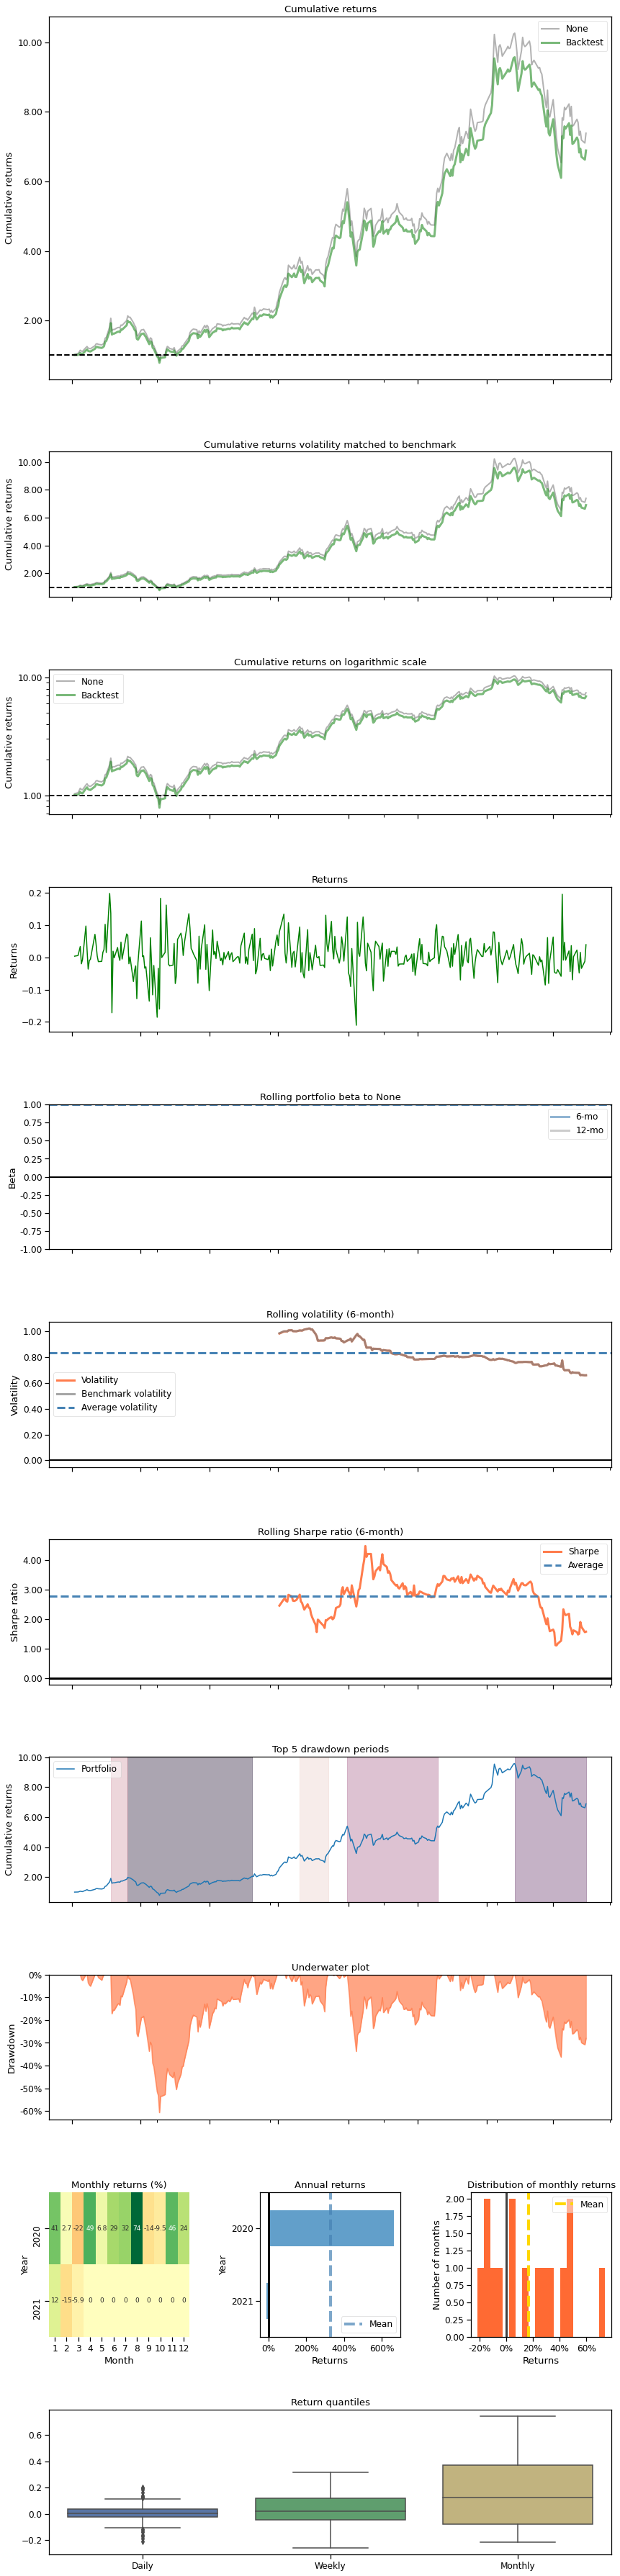

In [ ]:
print("Plotting Results")
%matplotlib inline
BackTestPlot(df_account_value_ppo, baseline_ticker = 'TSLA') 

In [ ]:
!pip install pyngrok

In [ ]:
!ngrok authtoken xxxxxxxxxxxxx

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
def generate_table(dataframe,max_rows=1000):
   return html.Table(
      # Header
      [html.Tr([html.Th(col,style={'border':'1px solid black','backgroundColor': 'rgb(260, 250, 200)','fontWeight': 'bold'}) for col in dataframe.columns])] +
      # Body
      [html.Tr([
         html.Td(dataframe.iloc[i][col],style={'border':'1px solid black'}) for col in dataframe.columns
      ]) for i in range(min(len(dataframe), max_rows))]
   ,style={'margin-left':'auto','margin-right':'auto','border':'1px solid black','width':'80%','text-align':'center','backgroundColor':'LightGrey'})
!pip install jupyter-dash
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objects as go
import dash_table
from dash.dependencies import Input, Output# Load Data
df = px.data.tips()# Build App
app = JupyterDash(__name__)
image_filename = 'download.png' # replace with your own image
encoded_image = base64.b64encode(open(image_filename, 'rb').read())
def chart():
    xi=[40, 7.6, 7.5,6.5,4.5,3.2,2.9,2.8,2.8,2]
    yi=['US', 'Japan', 'China','Hong Kong','UK','France','Germany','India','Canada','Switzerland']
    
    fig = go.Figure(go.Bar(x=xi,y=yi,text=xi,textposition='auto',orientation='h'))
    fig.layout.plot_bgcolor = 'Ivory'
    fig.layout.paper_bgcolor = 'AliceBlue'
    return fig
def chart1():
    lab = ['Deposits','Insurance Funds','Provident And Pension Funds','Currency','Shares/Stocks','Claims On Government']
    valu = [44,19,14,13,6,4]
    fig1 = go.Figure(data=[go.Pie(labels=lab, values=valu)])
    fig1.layout.plot_bgcolor = 'Ivory'
    fig1.layout.paper_bgcolor = 'AliceBlue'
    return fig1
def chart2():
    xa=['EU-27','Others','UK','US']
    ya=[13,27,5,55]
    fig2 = go.Figure(go.Bar(x=xa,y=ya,text=ya,textposition='auto'))
    fig2.layout.plot_bgcolor = 'Ivory'
    fig2.layout.paper_bgcolor = 'AliceBlue'
    return fig2

app.layout = html.Div([
    html.Br(),
    html.Br(), 
    html.Br(),
    html.Br(),   
    html.Br(),              
    
    html.H1("INTRODUCTION TO STOCK MARKET",style={'color': 'blue', 'text-align':'center'}),
    html.Br(),
    html.Div(children = [
        html.Iframe(src="https://www.youtube.com/embed/p7HKvqRI_Bo",
                style={'height':'400px','width':'800px'})
    ],style={'margin-left':'auto','margin-right':'auto','width':'60%'}),
    
    html.Br(),
    html.Br(),
    html.Br(),
    html.Br(),
    html.Br(), 
    html.H1("SOME STOCK MARKET STATISTICS",style={'color': 'green', 'text-align':'center'}),
    html.Br(),
    html.Br(),
    html.Div([
              html.Div([
                        html.H2("Percentage Of World Stock Market Cap By Country",style={'color': 'brown', 'text-align':'center'}),
                        html.Div([
                              dcc.Graph(
                                      id='figure1',
                                      figure=chart()
                                  )
                              ],style={'height':'100%'})
                    ],style={'display':'inline-block',
                                    'text-align':'center',
                                    'width':'33.3%'}),

                    html.Div([
                        html.H2("Where Do Indians Invest Their Money?",style={'color': 'orange', 'text-align':'center'}),
                        html.Div([
                              dcc.Graph(
                                      id='figure2',
                                      figure=chart1()
                                  )
                              ],style={'height':'100%'})
                    ],style={'display':'inline-block',
                                    'text-align':'center',
                                    'width':'33.3%',}),
                    html.Div([
                        html.H2("Market Share By Region In Percent",style={'color': 'magenta', 'text-align':'center'}),
                        html.Div([
                              dcc.Graph(
                                      id='figure3',
                                      figure=chart2()
                                  )
                              ],style={'height':'100%'})
                    ],style={'display':'inline-block',
                                    'text-align':'center',
                                    'width':'33.3%','align':'center'}),
    ]),
    html.Br(),
    html.Br(),
    html.Br(),
    
   
    html.H1("STOCK PRICE PREDICTION",style={'color': 'black', 'text-align':'center'}),
    html.Br(),
    html.Br(),
    html.Br(),
    html.Div([
        html.Div([
            html.H2("PREDICTED OUTPUTS",style={'color': 'red', 'text-align':'center'}),
            generate_table(res)
        ],style={'display':'inline-block',
                        'text-align':'center',
                        'width':'50%',}),

        html.Div([
            html.H2("RESULTS",style={'color': 'purple', 'text-align':'center'}),
            generate_table(abc)
        ],style={'display':'inline-block',
                        'text-align':'center',
                        'width':'50%',}),
    ]),
    html.Br(),
    html.Br(),
    html.Br(),
    html.Br(), 
    html.Br(), 
    html.Br(), 
    html.H1("OUTPUT ANALYSIS OF OUR STOCK PRICE PREDICTION MODEL",style={'color': 'DarkSlateBlue', 'text-align':'center'}),
    html.Br(),
    html.Br(),
    html.Br(),
    html.Div([
            html.Img(src='data:image/png;base64,{}'.format(encoded_image.decode()))
    ],style={'text-align':'center'})
],style={'background-color': 'AliceBlue'})# Define callback to update graph


In [ ]:
app.run_server(mode='external', port=2120)

Dash app running on:


<IPython.core.display.Javascript object>